# 08.02 - Operaciones Espaciales

**Autor:** Miguel Angel Vazquez Varela  
**Nivel:** Intermedio  
**Tiempo estimado:** 30 min

---

## Que aprenderemos?

- Calcular distancias
- Buffers (areas de influencia)
- Relaciones espaciales (contains, intersects, within)
- Spatial joins
- Agregacion espacial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import geopandas as gpd
    from shapely.geometry import Point, Polygon, box
    GEOPANDAS_AVAILABLE = True
    print(f"geopandas version: {gpd.__version__}")
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("geopandas no instalado. pip install geopandas")

geopandas version: 1.0.1


---

## Datos de ejemplo

In [2]:
if GEOPANDAS_AVAILABLE:
    # Estaciones de bici
    stations = gpd.GeoDataFrame({
        'name': ['Sol', 'Atocha', 'Cibeles', 'Retiro', 'Gran Via', 'Lavapies', 'Opera'],
        'bikes': [15, 22, 8, 12, 18, 10, 14],
        'geometry': gpd.points_from_xy(
            [-3.7038, -3.6893, -3.6921, -3.6844, -3.7065, -3.7012, -3.7098],
            [40.4168, 40.4065, 40.4197, 40.4153, 40.4203, 40.4095, 40.4180]
        )
    }, crs="EPSG:4326")
    
    # Distritos (poligonos simplificados)
    districts = gpd.GeoDataFrame({
        'district': ['Centro', 'Retiro', 'Salamanca'],
        'population': [150000, 120000, 145000],
        'geometry': [
            Polygon([(-3.715, 40.41), (-3.70, 40.41), (-3.70, 40.425), (-3.715, 40.425)]),
            Polygon([(-3.695, 40.405), (-3.68, 40.405), (-3.68, 40.42), (-3.695, 40.42)]),
            Polygon([(-3.695, 40.42), (-3.68, 40.42), (-3.68, 40.435), (-3.695, 40.435)])
        ]
    }, crs="EPSG:4326")
    
    print("Estaciones:")
    display(stations)
    print("\nDistritos:")
    display(districts)

Estaciones:


,name,bikes,geometry
0,Sol,15,POINT (-3.7038 40.4168)
1,Atocha,22,POINT (-3.6893 40.4065)
2,Cibeles,8,POINT (-3.6921 40.4197)
3,Retiro,12,POINT (-3.6844 40.4153)
4,Gran Via,18,POINT (-3.7065 40.4203)
5,Lavapies,10,POINT (-3.7012 40.4095)
6,Opera,14,POINT (-3.7098 40.418)



Distritos:


,district,population,geometry
0,Centro,150000,"POLYGON ((-3.715 40.41, -3.7 40.41, -3.7 40.42..."
1,Retiro,120000,"POLYGON ((-3.695 40.405, -3.68 40.405, -3.68 4..."
2,Salamanca,145000,"POLYGON ((-3.695 40.42, -3.68 40.42, -3.68 40...."


---

## 1. Calcular distancias

In [3]:
if GEOPANDAS_AVAILABLE:
    # Reproyectar a metros para distancias correctas
    stations_utm = stations.to_crs("EPSG:25830")
    
    # Punto de referencia: Puerta del Sol
    sol = stations_utm[stations_utm['name'] == 'Sol'].geometry.iloc[0]
    
    # Distancia desde Sol a todas las estaciones
    stations_utm['dist_to_sol'] = stations_utm.geometry.distance(sol)
    
    print("Distancia a Sol (metros):")
    stations_utm[['name', 'dist_to_sol']].sort_values('dist_to_sol')

Distancia a Sol (metros):


In [4]:
if GEOPANDAS_AVAILABLE:
    # Estaciones a menos de 1km de Sol
    nearby = stations_utm[stations_utm['dist_to_sol'] < 1000]
    print(f"Estaciones a menos de 1km de Sol: {len(nearby)}")
    print(nearby['name'].tolist())

Estaciones a menos de 1km de Sol: 4
['Sol', 'Gran Via', 'Lavapies', 'Opera']


---

## 2. Buffers (areas de influencia)

In [5]:
if GEOPANDAS_AVAILABLE:
    # Buffer de 500m alrededor de cada estacion
    stations_utm['buffer_500m'] = stations_utm.geometry.buffer(500)
    
    # Crear GeoDataFrame de buffers
    buffers = gpd.GeoDataFrame(
        stations_utm[['name', 'bikes']],
        geometry=stations_utm['buffer_500m'],
        crs=stations_utm.crs
    )
    
    buffers.head()

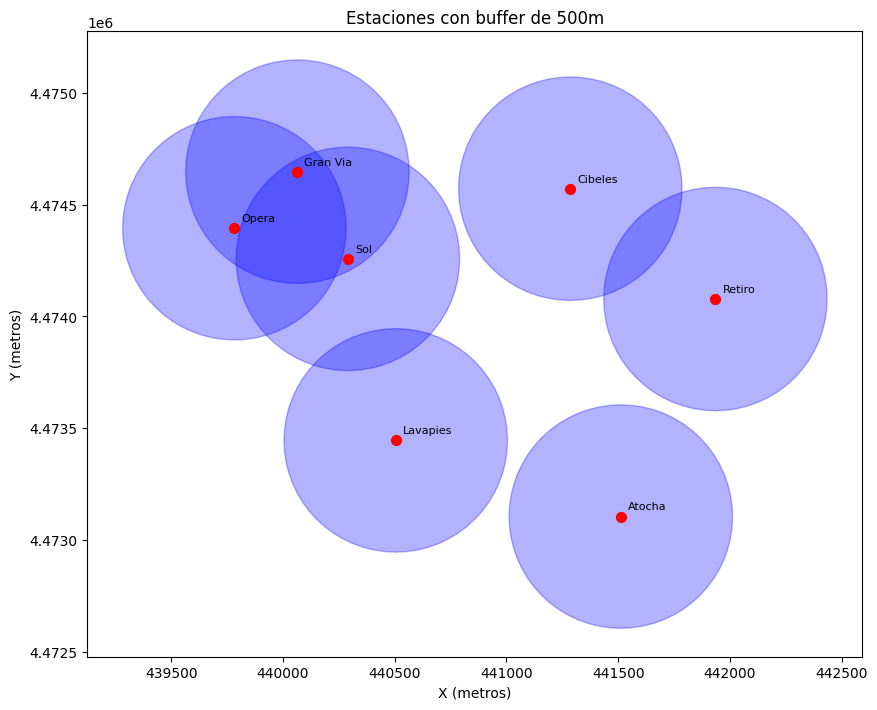

In [6]:
if GEOPANDAS_AVAILABLE:
    # Visualizar
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Buffers
    buffers.plot(ax=ax, alpha=0.3, color='blue', edgecolor='blue')
    
    # Estaciones
    stations_utm.plot(ax=ax, color='red', markersize=50, zorder=5)
    
    # Etiquetas
    for idx, row in stations_utm.iterrows():
        ax.annotate(row['name'], xy=(row.geometry.x, row.geometry.y),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_title('Estaciones con buffer de 500m', fontsize=12)
    ax.set_xlabel('X (metros)')
    ax.set_ylabel('Y (metros)')
    
    plt.show()

In [7]:
if GEOPANDAS_AVAILABLE:
    # Area de cobertura total (union de buffers)
    coverage = buffers.unary_union
    print(f"Area de cobertura: {coverage.area/1e6:.2f} km2")

Area de cobertura: 4.53 km2


C:\Users\miguel.vazquez\AppData\Local\Temp\ipykernel_32988\3696588347.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coverage = buffers.unary_union


---

## 3. Relaciones espaciales

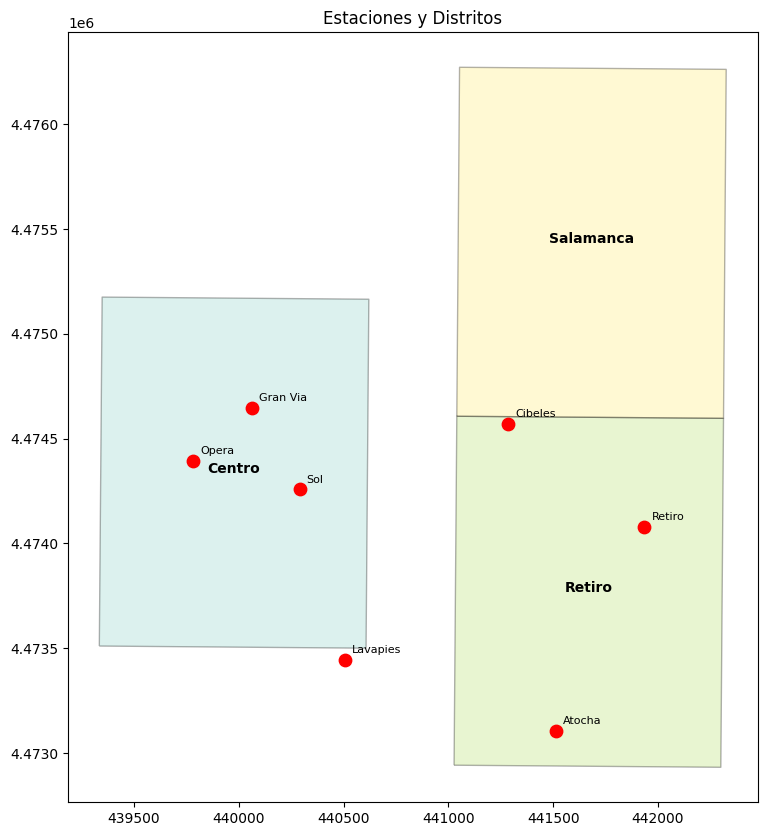

In [8]:
if GEOPANDAS_AVAILABLE:
    # Volver a WGS84 para trabajar con distritos
    districts_utm = districts.to_crs("EPSG:25830")
    
    # Visualizar estaciones y distritos
    fig, ax = plt.subplots(figsize=(10, 10))
    
    districts_utm.plot(ax=ax, alpha=0.3, edgecolor='black', cmap='Set3')
    stations_utm.plot(ax=ax, color='red', markersize=80, zorder=5)
    
    # Etiquetas distritos
    for idx, row in districts_utm.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(row['district'], xy=(centroid.x, centroid.y),
                    ha='center', fontsize=10, fontweight='bold')
    
    # Etiquetas estaciones
    for idx, row in stations_utm.iterrows():
        ax.annotate(row['name'], xy=(row.geometry.x, row.geometry.y),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_title('Estaciones y Distritos')
    plt.show()

In [9]:
if GEOPANDAS_AVAILABLE:
    # within: punto dentro de poligono
    centro = districts_utm[districts_utm['district'] == 'Centro'].geometry.iloc[0]
    
    stations_utm['in_centro'] = stations_utm.geometry.within(centro)
    
    print("Estaciones en Centro:")
    print(stations_utm[stations_utm['in_centro']][['name', 'bikes']])

Estaciones en Centro:
       name  bikes
0       Sol     15
4  Gran Via     18
6     Opera     14


In [10]:
if GEOPANDAS_AVAILABLE:
    # intersects: geometria toca o cruza otra
    buffer_sol = stations_utm[stations_utm['name'] == 'Sol'].geometry.iloc[0].buffer(800)
    
    stations_utm['near_sol'] = stations_utm.geometry.intersects(buffer_sol)
    
    print("Estaciones a menos de 800m de Sol:")
    print(stations_utm[stations_utm['near_sol']][['name', 'dist_to_sol']])

Estaciones a menos de 800m de Sol:


       name  dist_to_sol
0       Sol     0.000000
4  Gran Via   451.013282
6     Opera   526.188019


---

## 4. Spatial Join

In [11]:
if GEOPANDAS_AVAILABLE:
    # Asignar distrito a cada estacion
    stations_with_district = gpd.sjoin(
        stations_utm,
        districts_utm[['district', 'population', 'geometry']],
        how='left',
        predicate='within'
    )
    
    stations_with_district[['name', 'bikes', 'district', 'population']]

In [12]:
if GEOPANDAS_AVAILABLE:
    # Estaciones sin distrito asignado (fuera de los poligonos)
    no_district = stations_with_district[stations_with_district['district'].isna()]
    print(f"Estaciones sin distrito: {len(no_district)}")
    if len(no_district) > 0:
        print(no_district['name'].tolist())

Estaciones sin distrito: 1
['Lavapies']


---

## 5. Agregacion espacial

In [13]:
if GEOPANDAS_AVAILABLE:
    # Contar estaciones por distrito
    stations_per_district = stations_with_district.groupby('district').agg({
        'name': 'count',
        'bikes': 'sum'
    }).rename(columns={'name': 'num_stations', 'bikes': 'total_bikes'})
    
    stations_per_district

In [14]:
if GEOPANDAS_AVAILABLE:
    # Unir con geometria de distritos
    districts_stats = districts_utm.merge(
        stations_per_district,
        on='district',
        how='left'
    ).fillna(0)
    
    # Bicis por 10,000 habitantes
    districts_stats['bikes_per_10k'] = (
        districts_stats['total_bikes'] / districts_stats['population'] * 10000
    )
    
    districts_stats[['district', 'num_stations', 'total_bikes', 'bikes_per_10k']]

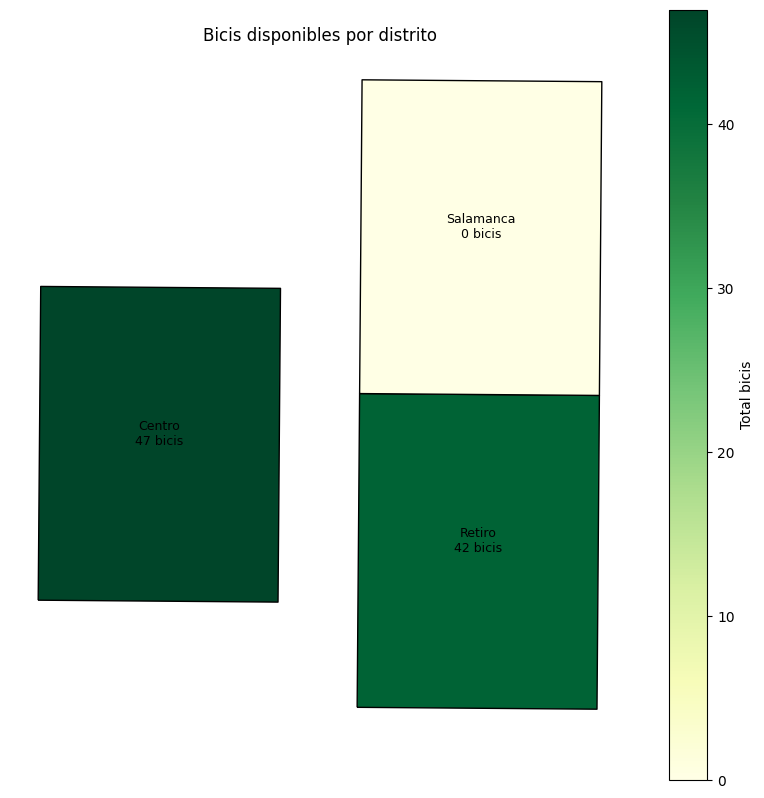

In [15]:
if GEOPANDAS_AVAILABLE:
    # Mapa coropletico
    fig, ax = plt.subplots(figsize=(10, 10))
    
    districts_stats.plot(
        ax=ax,
        column='total_bikes',
        cmap='YlGn',
        legend=True,
        edgecolor='black',
        linewidth=1,
        legend_kwds={'label': 'Total bicis'}
    )
    
    # Etiquetas
    for idx, row in districts_stats.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(
            f"{row['district']}\n{int(row['total_bikes'])} bicis",
            xy=(centroid.x, centroid.y),
            ha='center', fontsize=9
        )
    
    ax.set_title('Bicis disponibles por distrito', fontsize=12)
    ax.axis('off')
    plt.show()

---

## 6. Nearest neighbor

In [16]:
if GEOPANDAS_AVAILABLE:
    # Punto de interes: un usuario
    user_location = Point(440000, 4475000)  # Coordenadas UTM
    
    # Calcular distancia a todas las estaciones
    stations_utm['dist_to_user'] = stations_utm.geometry.distance(user_location)
    
    # Estacion mas cercana
    nearest = stations_utm.loc[stations_utm['dist_to_user'].idxmin()]
    
    print(f"Estacion mas cercana: {nearest['name']}")
    print(f"Distancia: {nearest['dist_to_user']:.0f} metros")
    print(f"Bicis disponibles: {nearest['bikes']}")

Estacion mas cercana: Gran Via
Distancia: 358 metros
Bicis disponibles: 18


In [17]:
if GEOPANDAS_AVAILABLE:
    # Top 3 estaciones mas cercanas
    top3 = stations_utm.nsmallest(3, 'dist_to_user')[['name', 'bikes', 'dist_to_user']]
    print("Top 3 estaciones mas cercanas:")
    top3

Top 3 estaciones mas cercanas:


---

## Resumen

| Operacion | Metodo |
|-----------|--------|
| Distancia | `gdf.distance(geom)` |
| Buffer | `gdf.buffer(dist)` |
| Dentro de | `gdf.within(polygon)` |
| Intersecta | `gdf.intersects(geom)` |
| Contiene | `polygon.contains(point)` |
| Spatial join | `gpd.sjoin(gdf1, gdf2)` |
| Union | `gdf.unary_union` |

**Importante:** Para distancias en metros, reproyectar a CRS proyectado (ej: UTM)

---

**Anterior:** [08.01 - Introduccion GeoPandas](08_01_geopandas_intro.ipynb)  
**Siguiente:** [08.03 - Mapas Interactivos con Folium](08_03_folium_maps.ipynb)